<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainSAPClassifier_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import spacy
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [ ]:
stats_vocab = ['pe',
 'sap',
 'tabulated',
 'hazard',
 'inferiority',
 'categorical',
 'meddra',
 'residual',
 'itt',
 'continuous',
 'summarised',
 'variables',
 'brv',
 'variable',
 'cox',
 'listings',
 'laz',
 'statistics',
 'descriptive',
 'regression',
 'proportional',
 'hazards',
 'sided',
 'deviation',
 'presented',
 'corresponding',
 'percentage',
 'calculated',
 'analysed',
 'censored',
 'derived',
 'coding',
 'cumulative',
 'seroconversion',
 'soc',
 'tables',
 'proportion',
 'covariates',
 'survival',
 'deviations',
 'pv',
 'interim',
 'class',
 'hypothesis',
 'sensitivity',
 'power',
 'ratio',
 'summarized',
 'median',
 'measurements',
 'model',
 'endpoint',
 'exploratory',
 'statistical',
 'plan',
 'confidence',
 'log',
 'ipm',
 'estimate',
 'planned',
 'demographic',
 'classified',
 '95%',
 'solicited',
 'iu',
 'significance',
 'adjusted',
 'pq',
 'randomisation',
 'ci',
 'values',
 'differences',
 'measures',
 'signed',
 'outcomes',
 'assigned',
 'analyses',
 'overview',
 'intervals',
 'randomised',
 'measurement',
 '90%',
 'versus',
 'analysis',
 'point',
 'adherence',
 'interval',
 'secondary',
 'value',
 'groups',
 'estimated',
 'mean',
 'relative',
 'treat',
 'frequency',
 'outcome',
 'detect',
 'discharge',
 'distribution',
 'baseline',
 'endpoints',
 'dsmb',
 'objectives',
 'efficacy',
 'method',
 'negative',
 'concentration',
 'assessed',
 'confirmed',
 'table',
 'fluid',
 'ae',
 'rate',
 'death',
 'stopping',
 'cd',
 'self',
 'otherwise',
 'parameters',
 'maximum',
 'compared',
 'multiple',
 'crf',
 'type',
 'general',
 'incidence',
 'defined',
 'function',
 '50%',
 'scheduled',
 'considerations',
 'methods',
 'reported',
 'expected',
 'period',
 'meeting',
 'details',
 'first',
 'aes',
 'occurring',
 'doses',
 'rates',
 'count',
 'received',
 'completed',
 'relationship',
 'status',
 'occurrence',
 'placebo',
 'specified']

In [ ]:
stats_vocab_regex = re.compile(r'(?i)\b(' + "|".join(stats_vocab) + r"\b)")

In [ ]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [ ]:
import operator
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    page_to_num_matches = {}
    pages_to_save = []
    for page_no, page in enumerate(pages):
      if type(page) is str:
        num_matches = len(stats_vocab_regex.findall(page))
        page_to_num_matches[page_no] = num_matches
    for page, _ in sorted(page_to_num_matches.items(), key=operator.itemgetter(1), reverse=True):
      pages_to_save.append(page)
      if len(pages_to_save) >= 10:
        break

    texts.append(" ".join([pages[page] for page in pages_to_save]))
df_annotations["text"] = texts

In [ ]:
 del file_to_pages

In [ ]:
df_annotations = df_annotations[~df_annotations.has_sap.isna()]

In [ ]:
df_annotations["has_sap"].value_counts()

0    6150
1    5774
Name: has_sap, dtype: int64

In [ ]:
labels = ["0","1"]

In [ ]:
import spacy
nlp = spacy.blank("en")
from spacy.tokens import DocBin

docs_train = []
for i in range(10):
  docs_train.append(DocBin())
docs_val = DocBin()

for idx in range(len(df_annotations)):
  if idx % 100 == 0:
    print (idx, len(df_annotations))
  if df_annotations.train_val.iloc[idx] == "train":
    docs_list = docs_train[idx % 10]
  else:
    docs_list = docs_val
  text = str(df_annotations.text.iloc[idx])
  if len(text) > 100000:
      text = text[:100000]
  doc = nlp(text)

  cats = {}
  for a in labels:
      cats[a] = 0
  if pd.isna(df_annotations.has_sap.iloc[idx]):
    continue
  cats[str(int(df_annotations.has_sap.iloc[idx]))] = 1
  doc.cats = cats

  docs_list.add(doc)

In [ ]:
!mkdir train.spacy
!mkdir /content/drive/MyDrive/data/sap_01_train.spacy


In [ ]:
for idx, doc_bin_train in enumerate(docs_train):
  doc_bin_train.to_disk(f"train.spacy/train_doc_bin{idx}.spacy")
  doc_bin_train.to_disk(f"/content/drive/MyDrive/data/sap_01_train.spacy/train_doc_bin{idx}.spacy")

In [ ]:
!ls /content/drive/MyDrive/data/sap_01_train.spacy

train_doc_bin0.spacy  train_doc_bin4.spacy  train_doc_bin8.spacy
train_doc_bin1.spacy  train_doc_bin5.spacy  train_doc_bin9.spacy
train_doc_bin2.spacy  train_doc_bin6.spacy
train_doc_bin3.spacy  train_doc_bin7.spacy


In [ ]:
docs_val.to_disk("dev.spacy")

In [ ]:
docs_val.to_disk("/content/drive/MyDrive/data/sap_01_dev.spacy")

In [ ]:
!python -m spacy train ./spacy_textcat_is_international_11.cfg --output /content/drive/MyDrive/data/output_sap_01 --paths.train /content/drive/MyDrive/data/sap_01_train.spacy --paths.dev  /content/drive/MyDrive/data/sap_01_dev.spacy --gpu-id 0

✔ Created output directory:
/content/drive/MyDrive/data/output_sap_01
ℹ Saving to output directory:
/content/drive/MyDrive/data/output_sap_01
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-11-18 11:40:25,886] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-18 11:40:25,897] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-11-18 11:40:25,901] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-18 11:40:25,901] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
tcmalloc: large alloc 1073750016 bytes == 0xb8c14000 @  0x7f59593452a4 0x58ead6 0x441ff3 0x5d1f81 0x5d2306 0x58f62c 0x5105e2 0x58fd37 0x50ca37 0x58fd37 0x50ca37 0x4d01b4 0x50cb8d 0x4d01b4 0x50cb8d 0x4d01b4 0x7f57edcea7c6 0x4ba72b 0x7f57edce8ce3 0x58f6e4 0x50ff13 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b575e 0x58ff2e 0x50d482 0x5b575e 0x58ff2e
[2022-11-18 11:54:02,555] [

In [29]:
import spacy
nlp = spacy.load("/content/drive/MyDrive/data/output_sap_01/model-best")

In [30]:
df_val = df_annotations[df_annotations.train_val=="val"]

predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [31]:
# pred_proba = []
# for idx in range(len(df_val)):
#     pred_proba.append([predictions[idx][a] for a in range(num_classes)])

In [32]:
predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [33]:
df_val["y_pred"] = [max(p, key=p.get) for p in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
sap_ground_truths = df_val.has_sap
pred_sap = df_val["y_pred"]

In [35]:
sap_ground_truths = df_val.has_sap.apply(int).apply(str)

In [36]:
acc = accuracy_score(sap_ground_truths, pred_sap)
print (f"SAP accuracy {acc}")

SAP accuracy 0.656221198156682


''

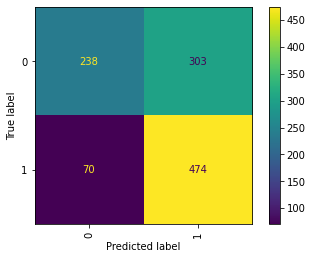

In [37]:
ConfusionMatrixDisplay.from_predictions(sap_ground_truths, pred_sap, labels=labels)
plt.xticks(rotation=90)
;

In [38]:
all_aucs = []
from sklearn.metrics import roc_auc_score
for i in labels:
  roc_auc = roc_auc_score(sap_ground_truths == i, [p[i] for p in predictions])
  print (f"SAP ROC AUC {roc_auc} for {i} subjects")
  all_aucs.append(roc_auc)
print ("Average", np.mean(all_aucs))

SAP ROC AUC 0.7692148254865718 for 0 subjects
SAP ROC AUC 0.7692216211808198 for 1 subjects
Average 0.7692182233336958


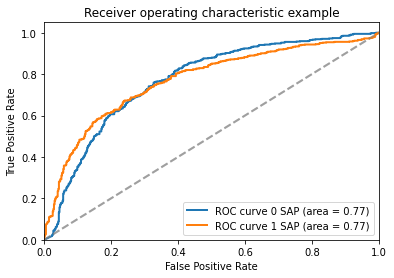

In [39]:
plt.figure()
lw = 2
    
for i in labels:
    fpr, tpr, _ = roc_curve(sap_ground_truths == i, [p[i] for p in predictions])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve {i} SAP (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()